

# Ephaptic Coupling #

### Import stuff

In [1]:
%pylab inline

import numpy as np
import sys
if sys.version < '3':
    from urllib2 import urlopen
else:    
    from urllib.request import urlopen
import ssl
from warnings import warn
import zipfile
import os
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
import LFPy
import neuron
from neuron import h
from custom_plots import plot_cell
import ipywidgets as wdg

Populating the interactive namespace from numpy and matplotlib


### Define morphology and cell parameters

Pyramidal cell:
    'morphology' : 'morphology/pyramidal_layer5.hoc',
    'cm' : 0.75,                      
    'Ra' : 150,                
    'v_init' : -70,  
    'g_pas' : 1/30000,
    'tau': 15,

https://senselab.med.yale.edu/ModelDB/showmodel.cshtml?model=2488#tabs-1
sci-hub.tw/10.1038/382363a0
https://neuroelectro.org/neuron/111/


Mitral cell:
    'morphology' : 'morphology/mitral/mitral.hoc',
    'cm' : 1.8,                         
    'Ra' : 54,                
    'v_init' : -62,    
    'tau' : 9.5,
    'g_pas': 1/9600,

https://senselab.med.yale.edu/ModelDB/ShowModel?model=53435&file=/anyas2005/model_bf_HPP/morphology.hoc#tabs-1
https://nyaspubs.onlinelibrary.wiley.com/doi/epdf/10.1196/annals.1342.033
https://neuroelectro.org/neuron/129/


Purkinje cell:
    'morphology' : 'morphology/purkinje.hoc',
    'cm' : 0.65,                   
    'Ra' : 120,                
    'v_init' : -62,  
    'tau': 7.6,
    'g_pas': 1/120236,
   
https://senselab.med.yale.edu/ModelDB/ShowModel?model=243446&file=/purkinje_pub/purkinje_demo.hoc#tabs-1Ra 
https://www.jneurosci.org/content/jneuro/25/2/464.full.pdf
https://neuroelectro.org/neuron/18/

In [2]:
# define cell parameters used as input to cell-class
cellParameters = {
    'morphology' : 'morphology/pyramidal_layer5.hoc',
    'cm' : 0.75,                      
    'Ra' : 150,                
    'v_init' : -70, 
    'passive' : True,           # turn on NEURONs passive mechanism for all sections
    'nsegs_method' : None,      # spatial discretization method
    'dt' : 2**-6,               # simulation time step size
    'tstart' : -200,               # start time of simulation
    'tstop' : 200,               # stop simulation
    'celsius': 34,
    'pt3d' : True,
    'extracellular': True,
    'passive_parameters' : {'g_pas' : 1/30000, 'e_pas' : -65},
}

In [3]:
# test with mod mechanisms

# #compile mod files every time, because of incompatibility with Mainen96 files:
# if "win32" in sys.platform:
#     pth = "pyramidal_mod/"
#     warn("no autompile of NMODL (.mod) files on Windows.\n" 
#          + "Run mknrndll from NEURON bash in the folder L5bPCmodelsEH/mod and rerun example script")
#     if not pth in neuron.nrn_dll_loaded:
#         neuron.h.nrn_load_dll(pth+"nrnmech.dll")
#     neuron.nrn_dll_loaded.append(pth)
# else:
#     os.system('''
#               cd morphology/pyramidal_mod/
#               nrnivmodl
#               ''')
#     neuron.load_mechanisms('morphology/pyramidal_mod/')

# cellParameters = {
#     'morphology' : 'morphology/pyramidal_layer5.hoc',
# #     'cm' : 0.75,                      
# #     'Ra' : 150,                
# #     'v_init' : -70, 
#     'passive' : False,           # turn on NEURONs passive mechanism for all sections
#     'nsegs_method' : None,      # spatial discretization method
#     'dt' : 2**-6,               # simulation time step size
#     'tstart' : 0,               # start time of simulation
#     'tstop' : 200,               # stop simulation
#     'celsius': 34,
#     'pt3d' : True,
#     'extracellular': True,
# #     'passive_parameters' : {'g_pas' : 0.000001, 'e_pas' : -65},
# }

## Create generator_cell

Synapse target index is: 0
Synapse target position is: [0. 0.]


Text(0, 0.5, 'Cell compartment (zmid)')

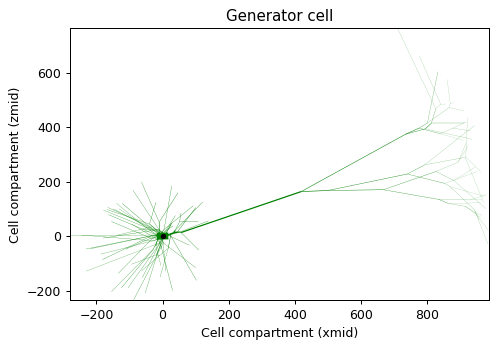

In [4]:
# delete old sections from NEURON namespace
LFPy.cell.neuron.h("forall delete_section()")

# initialize cell instance, using the LFPy.Cell class
generator_cell = LFPy.Cell(**cellParameters)
generator_cell.set_rotation(x=4.729, y=-3.166)


# create synapse
synapse_parameters = {
    'idx' : generator_cell.get_closest_idx(x=0, y=0, z=0),  # place sinapse at soma coordinates
    'e' : 0,                     # reversal potential
    'syntype' : 'ExpSyn',        # synapse type
    'tau' : 10,                  # synaptic time constant
    'weight' : 0.005,            # synaptic weight
    'record_current' : True,     # record synapse current
}

synapse = LFPy.Synapse(generator_cell, **synapse_parameters)
synapse.set_spike_times(np.array([100,120]))      # spike times

# check synapse location 
positions = np.array(list(zip(generator_cell.xmid, generator_cell.zmid)))  # array all cell positions
synapse_index = generator_cell.get_closest_idx(x=0, y=0, z=0)              # find closest electrode to target position
synapse_pos = positions[synapse_index] 

print('Synapse target index is:', synapse_index)
print('Synapse target position is:', synapse_pos)

# plot generator cell morphology with synapse location
plt.figure(figsize=(6,4), dpi=90)
plot_cell(generator_cell, color='g')
plt.scatter(generator_cell.xmid[0],generator_cell.zmid[0], s=10, color='k')
plt.title('Generator cell')
plt.xlabel('Cell compartment (xmid)')
plt.ylabel('Cell compartment (zmid)')

### Measure external field in receptor_cell positions

In [5]:
# define parameters for extracellular recording electrodes
electrodeParameters = {
    'sigma' : 0.3,                  # extracellular conductivity
    'x' : generator_cell.xmid,      
    'y' : generator_cell.ymid,
    'z' : generator_cell.zmid,
    'method' : 'soma_as_point',     #sphere source soma segment
    'N' : np.array([[0, 1, 0]]*generator_cell.xmid.size), #surface normals
    'r' : 2.5,                      # contact site radius
    'n' : 20,                       # datapoints for averaging
}

# create extracellular electrode object for LFPs on grid in xz-plane
electrode = LFPy.RecExtElectrode(**electrodeParameters)

# simulate generator cell
generator_cell.simulate(electrode = electrode,rec_vmem=True)

Adjusting r-distance to soma segments
Adjusting r-distance to soma segments
Adjusting r-distance to soma segments
Adjusting r-distance to soma segments
Adjusting r-distance to soma segments
Adjusting r-distance to soma segments
Adjusting r-distance to soma segments
Adjusting r-distance to soma segments
Adjusting r-distance to soma segments
Adjusting r-distance to soma segments
Adjusting r-distance to soma segments
Adjusting r-distance to soma segments
Adjusting r-distance to soma segments
Adjusting r-distance to soma segments
Adjusting r-distance to soma segments
Adjusting r-distance to soma segments
Adjusting r-distance to soma segments
Adjusting r-distance to soma segments
Adjusting r-distance to soma segments
Adjusting r-distance to soma segments
Adjusting r-distance to soma segments
Adjusting r-distance to soma segments
Adjusting r-distance to soma segments
Adjusting r-distance to soma segments
Adjusting r-distance to soma segments
Adjusting r-distance to soma segments
Adjusting r-

### Plot Vmem in generator cell over time (to see spike propagation)

/home/renata/mygit/lascon-project/custom_plots.py:21: RuntimeWarning: invalid value encountered in true_divide
  normalized_voltage = (voltage - vmin)/(vmax-vmin)
/home/renata/anaconda3/lib/python3.7/site-packages/matplotlib/colors.py:527: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


Text(0, 0.5, 'Cell compartment (zmid)')

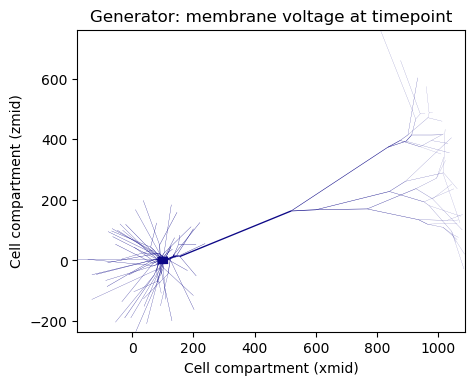

In [6]:
# plot generator cell vmem with morphology
target_ms = 10      # time in ms
timepoint = int(target_ms/(2**-6))    # simulation time point
plt.figure(figsize=(5, 4), dpi=100)
plot_cell(generator_cell, x_off=100, voltage=generator_cell.vmem[:,timepoint], palette='plasma')
plt.title('Generator: membrane voltage at timepoint')
plt.xlabel('Cell compartment (xmid)')
plt.ylabel('Cell compartment (zmid)')

# # plot generator cell vmem interactively over time
# def plot_time(t=100):
#     plot_cell(generator_cell, x_off=100, voltage=generator_cell.vmem[:,t], palette='plasma')
#     plt.title('Generator: membrane voltage over time')
# wdg.interact(plot_time)

## Creating receptor_cell

In [7]:
# delete old sections from NEURON namespace
LFPy.cell.neuron.h("forall delete_section()")

# initialize cell instance, using the LFPy.Cell class
receptor_cell = LFPy.Cell(**cellParameters)
receptor_cell.set_rotation(x=4.729, y=-3.166)
receptor_cell.xmid += 100          # added distance of the electrodes to the receptor cell in x plane

# time of extracellular field simulation
t = np.arange(electrode.LFP.shape[1]) * receptor_cell.dt

# insert external field generated by the generator cell recorded in electrodes
receptor_cell.insert_v_ext(electrode.LFP, t)

# perform receptor cell simulation
receptor_cell.simulate(rec_vmem=True)

Overwriting custom temperature of 34.00. New temperature is 34.00


### Find index positions of electrodes in the receptor cell

Target index is: 56
Target position is: [ 63.04475403 124.73866272]


Text(0, 0.5, 'Cell compartment (zmid)')

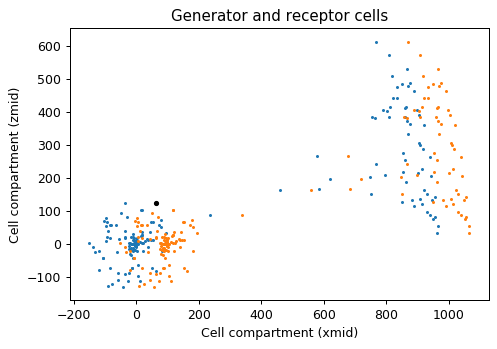

In [8]:
positions = np.array(list(zip(receptor_cell.xmid, receptor_cell.zmid)))  # array all cell positions
target_index = receptor_cell.get_closest_idx(x=200, y=0., z=600)         # find closest electrode to target position
target_pos = positions[target_index] 

print('Target index is:', target_index)
print('Target position is:', target_pos)

# plot generator and receptor compartments with target
plt.figure(figsize=(6,4), dpi=90)
plt.scatter(generator_cell.xmid, generator_cell.zmid ,s=2)  # blue
plt.scatter(receptor_cell.xmid, receptor_cell.zmid ,s=2)    # orange
plt.scatter(target_pos[0],target_pos[1],s=10,color='k')     # black dot = target position 
plt.title('Generator and receptor cells')
plt.xlabel('Cell compartment (xmid)')
plt.ylabel('Cell compartment (zmid)')

### Plot Vmem in receptor cell over time

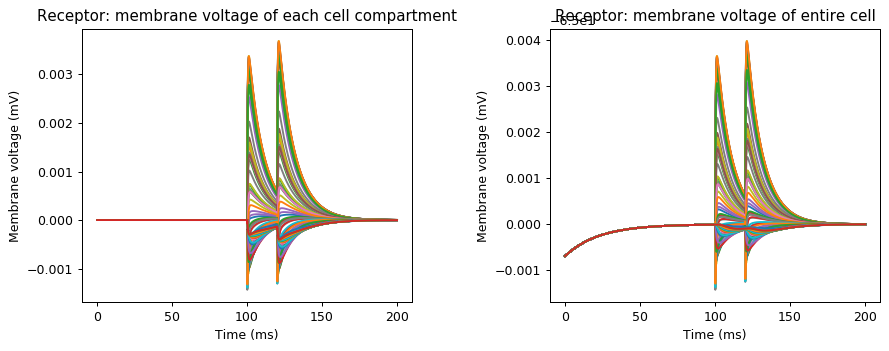

In [9]:
plt.figure(figsize=(10,4), dpi=90)

# plot vmem in each receptor cell compartment over time
plt.subplot(121)
plt.plot(receptor_cell.tvec,receptor_cell.vmem.T - receptor_cell.vmem.mean(axis=0).reshape(-1,1));
plt.title('Receptor: membrane voltage of each cell compartment')
plt.ylabel('Membrane voltage (mV)')
plt.xlabel('Time (ms)')

# plot vmem of all receptor cell compartments over time
plt.subplot(122)
plt.plot(receptor_cell.tvec,receptor_cell.vmem.T);
plt.title('Receptor: membrane voltage of entire cell')
plt.ylabel('Membrane voltage (mV)')
plt.xlabel('Time (ms)')

plt.tight_layout()

Text(0, 0.5, 'Cell compartment (zmid)')

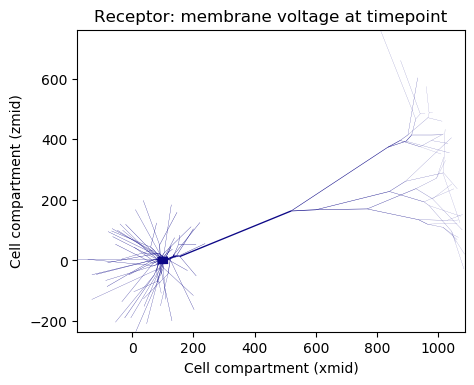

In [10]:
# plot receptor cell vmem with morphology
target_ms = 15      # time in ms
timepoint = int(target_ms/(2**-6))    # simulation time point
plt.figure(figsize=(5, 4), dpi=100)
plot_cell(receptor_cell, x_off=100, voltage=receptor_cell.vmem[:,timepoint], palette='plasma')
plt.title('Receptor: membrane voltage at timepoint')
plt.xlabel('Cell compartment (xmid)')
plt.ylabel('Cell compartment (zmid)')

# # plot receptor cell vmem interactively over time
# def plot_time(t=100):
#     plot_cell(receptor_cell, x_off=100, voltage=receptor_cell.vmem[:,t], palette='plasma')
#     plt.title('Receptor: membrane voltage over time')
# wdg.interact(plot_time)

### Plot of ephaptic coupling between the cells: Vmem in SOMA

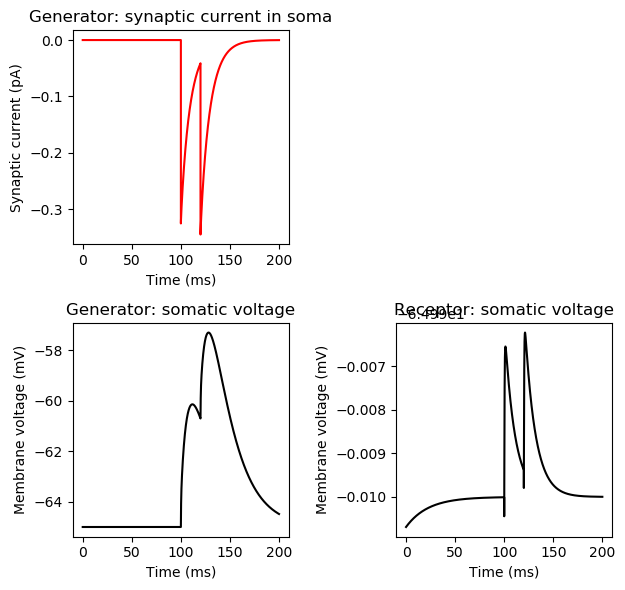

In [11]:
plt.figure(figsize=(9, 6), dpi=100)
plt.subplot(232)
plt.plot(generator_cell.tvec, synapse.i, 'r'), plt.title('Generator: synaptic current in soma')
plt.xlabel('Time (ms)')
plt.ylabel('Synaptic current (pA)')

plt.subplot(235)
plt.plot(generator_cell.tvec, generator_cell.somav, 'k'), plt.title('Generator: somatic voltage')
plt.xlabel('Time (ms)')
plt.ylabel('Membrane voltage (mV)')

plt.subplot(236)
plt.plot(receptor_cell.tvec, receptor_cell.somav, 'k'), plt.title('Receptor: somatic voltage')
plt.xlabel('Time (ms)')
plt.ylabel('Membrane voltage (mV)')

plt.tight_layout()

### Plot of ephaptic coupling between cells: Vmem of the indexed position 

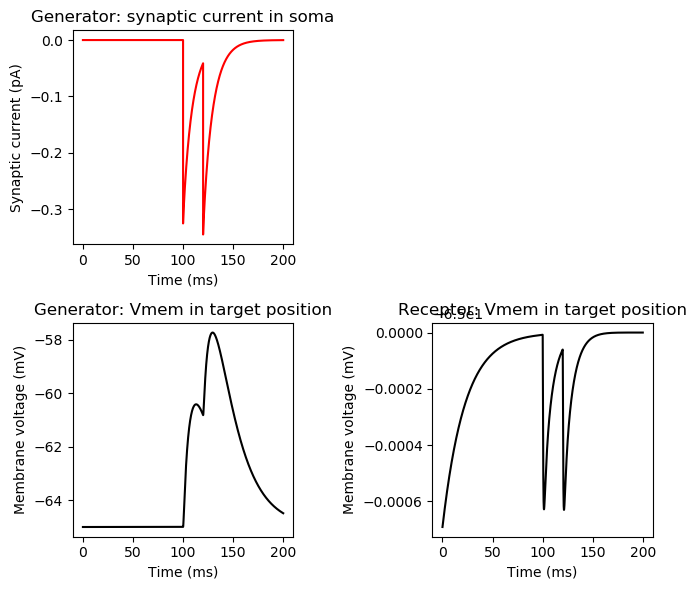

In [12]:
plt.figure(figsize=(10, 6), dpi=100)
plt.subplot(232)
plt.plot(generator_cell.tvec, synapse.i, 'r'), plt.title('Generator: synaptic current in soma')
plt.xlabel('Time (ms)')
plt.ylabel('Synaptic current (pA)')

plt.subplot(235)
plt.plot(generator_cell.tvec, generator_cell.vmem[target_index], 'k'), plt.title('Generator: Vmem in target position')
plt.xlabel('Time (ms)')
plt.ylabel('Membrane voltage (mV)')

plt.subplot(236)
plt.plot(receptor_cell.tvec, receptor_cell.vmem[target_index], 'k'), plt.title('Receptor: Vmem in target position')
plt.xlabel('Time (ms)')
plt.ylabel('Membrane voltage (mV)')

plt.tight_layout()